# Computing Project

# Monte Carlo and cluster algorithms for the 2D Ising Model and 2D Hard Disk module

The Ising model for ferromagnets is a common and well researched statistical mechanics problem both computationally and analytically. Many different algorithms with differing complexities and strengths are used to simulate the behaviour of this model. The behaviour and complexity of the Metropolis-Hastings and Wolff Cluster algorithms was investigated. This report focuses particularly on the simulated behaviour at and around the critical temperature $T_c$, where these models differ significantly. The efficiency of the algorithms is also calculated by means of the dynamic critical exponent.

## Section 1 - Background theory

The Ising model considers individual spins, $\sigma_i$, arranged in space. For the purposes of this report, we will place spins on an $L\times L$ square lattice. This model assumes that these individual spins may only be spin up or down, i.e. $\sigma_i = \pm 1$, and that each spin interacts with only its nearest neighbours on the lattice. The total energy of the system is then:

$ E = -J \sum_i \sum_j \sigma_i \sigma_j - \mu H \sum_i \sigma_i $ (1) [**CIT 7**]

where for each spin $i$ we sum over its nearest neighbours, $j$. Additionally, $J$ is the ferromagnetic coupling, $\mu$ is the spin's magnetic moment and $H$ is the external magnetic field. In this report, we will largely (COMPLETLEY??) be considering the zero external magnetic field approach.

Typical observables of interest for this system are the magnetism,

$ M  = \frac{1}{N} \sum_{i = 1}^N \sigma_i $ (2)

or, for ensemble systems, the expected total magnetism:

$ \mathbb{E}(M) = \sum_{\sigma states} M(\sigma)p(\sigma)$ (3)

with $p(\sigma)$ being the probabilty density for a specific $\sigma$ state. From statistical mechanics, recall that for such a system,

$ p(\sigma) = \frac{e^{- \beta E}}{Z} $ (4)

Where $Z = \sum_{states} e^{-\beta E_{state}}$ is the partition function, and $\beta = \frac{1}{k_b T}$. For convenience, $\beta = 1$ throughout this report.

However, for a general ising system, whilst $Z$ is constant it is feasibly calculable. To illustrate this consider an $N \times N$ lattice of spins. To compute $Z$, we must (at worst) sum up $2^N$ terms for each possible lattice configuration; this sum quickly becomes astronomic in scale. Hence, we must approach this problem in a manner that depends only on relative likelihood, not absolute probability.

In some limiting cases, the behaviour of this system is analytically solvable, for example the Onsager solution for 2 dimensions with no external field, this is typically tedious, or infeasibly complex. This is the motivation for studying this system with computational methods. However, comparison of computational methods to the establsihed Onsager solution is a convenient sanity check for the accuracy and precision.

### The Onsager Solution

In 1944, Onsager found an analytical expression for the free energy and magnetism of the 2D square lattice Ising model in the limit of large lattice and with no eternal magnetic field. Below is the solution for the magnetisation In the case relevant to this report, with isotropic couping:

$\mathbb{E}(M) = (1 - (sinh(2 \beta J)^{-4}))^{\frac{1}{8}} $ for $ T \le T_c $

$\mathbb{E}(M) = 0$ for $ T > T_c $ (5)

The non zero solution clearly is only defined if $sinh(2 \beta J) \ge 1$. This defines our *critical temperature*, $T_c = \frac{2 J}{ln(1 + \sqrt{2})} \approx 2.27J$ . There is a continuous phase transition at $T = T_c$ at which the spins rapidly transition from ordered to disordered. Below is a plot absolute mean magnetisation per spin for $J = 1$ for this solution:

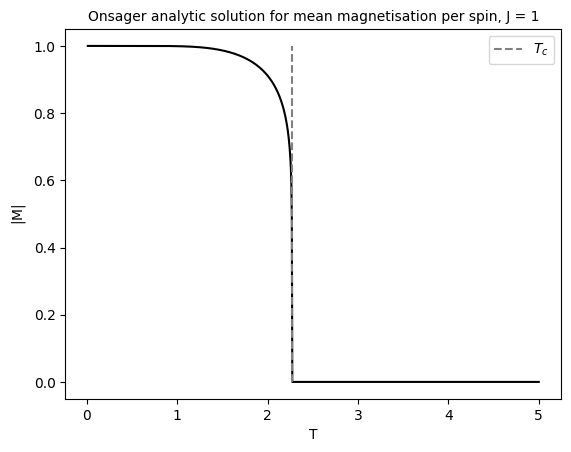

In [144]:
# Firstly, import necessary modules for our program:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
import time

# Plot Onsager solution, J = 1:
J = 1
Ts_analytic = np.linspace(0.01,5,1000)
T_c = 2*J/np.log(1 + np.sqrt(2)) # Critical temperature

# Construct absolute magnetism:
M_analytic = []

for T in Ts_analytic:
    if T < T_c:
        M_analytic.append(np.power(1 - np.power(np.sinh(2*J/T),-4),1/8))
    else:
        M_analytic.append(0)

# Plot:
plt.plot(Ts_analytic, M_analytic, color = 'black')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Onsager analytic solution for mean magnetisation per spin, J = ' + str(J), fontsize = 10)
plt.legend()
plt.show()

*Fig. 1*

## Section 2 - Set up

To begin, a model for the lattice must be produced on which to implement algorithms. For the purposes of this report, a square lattice with periodic boundary conditions is used. For example, the nearest neighbours of a spin situated of the right hand edge of the lattice will include a spin on the left hand edge in the same row. The lattice is initiated with a function that produces a list of $N$ items, with each item itself being a list of $N$ items. This trivially has shape $(N,N)$, with each spin having an index $(i,j)$. Each value will be $\pm 1$, and this function will be able to either initiate the lattice in a 'hot' state, with each spin being randomly assigned, or a 'cold' start, where all spins hold the same value. This code is included below, along with a function that allows a visual representation of an input lattice:

In [3]:


# Now, produce function that produces a lattice when given desired width and initial state:
def make_lattice(width, type):
    # type takes arguments setting initial spin config:
    # +/-1 sets lattice to all be +/-1, 0 for random initial spins

    if type != 0:
        lattice = type*np.ones((width,width))
    else:
        lattice = np.random.default_rng().choice([-1,1], (width,width))

    return lattice

# Finally, produce function that graphically displays the lattice as a colourmap, using a binary colour scheme due to the binary values in question:
def show_lattice(lattice, axis, title):
    # write a function to display our output lattices as an image:
    axis.matshow(lattice, cmap=plt.cm.binary, vmin = -1, vmax = 1)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(title, fontsize = 10)


Below are visualisations of the three possible initial conditions:

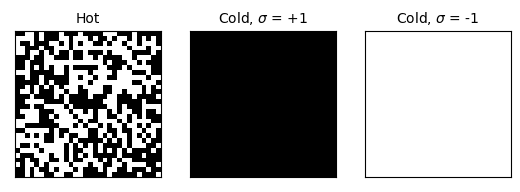

In [4]:
# Initialise lattices:
lattice_cold_plus = make_lattice(30,1)
lattice_cold_minus = make_lattice(30,-1)
lattice_hot = make_lattice(30,0)

# Plot lattices:
fig, ax = plt.subplots(1,3)
show_lattice(lattice_hot, ax[0], 'Hot')
show_lattice(lattice_cold_plus, ax[1], r'Cold, $\sigma$ = +1')
show_lattice(lattice_cold_minus, ax[2], r'Cold, $\sigma$ = -1')

*Fig. 2*

Additionally, a number of other helpful functions can be created to streamline our implementations. Firstly, to compute the energy of a lattice, the sum of nearest neighbour spins for each site is required. A function is included below that returns the 4 nearest neighbours of a give spin at $(i,j)$ including a consideration of the periodic boundary conditions by utilising a modulus function. A further function that returns the nearest neighbours spin sum is also included:

In [5]:

def near_neighbours(i, j, width):
    # using periodic BCs, must make sure spin sums correctly roll over, ie the neighbours of spin [width,width] include [0,width] 
    # etc. neighbours returned in the format (Right, Left, Up, Down)
    neighbours = [[(i+1)%width,j],[(i-1)%width,j],[i,(j-1)%width],[i,(j+1)%width]]
    return neighbours

def neighbouring_spins_sum(i, j, lattice, width):
    spin = 0
    neighbours = near_neighbours(i,j,width)
    for neighbour in neighbours:
        spin += lattice[neighbour[0],neighbour[1]]
    return spin

In [6]:
def compute_magnetisation(lattice):
    # finds overall magnetisation per spin of the lattice 
    M = np.sum(lattice)/np.size(lattice)
    return M

def compute_Chi(lattice, beta, M_Sample):
    # takes in a last of magnetisations from some sampling scheme
    # and returns susceptibility 
    return beta*np.size(lattice)*np.var(M_Sample)

## Section 3 - The algorithms

The two algorithms investigated are variations of a Markov Chain Monte Carlo (MCMC) method, that approach and evolve the desired physical state. Direct sampling Monte Carlo, while simpler, would require individually producing each state $X_i$. This is infeasibly slow. Instead, we use the MCMC methods, which produce a state $X_{i + 1}$ from an alteration of the $X_i$ state. One of the downsides of the MCMC methods is that this means consecutive states are not independent. This is quantified by the sample autocorrelation, discussed in more detail in section 4.

The MCMC starts with some initial state, $x_0$, and a state $x_{i+1}$ is produced from a state $x_i$ with a transition probability $p(x_{i + 1} \vert x_{i})$. Therefore the the chance of a particular sequence of states from $x_0$ to $x_n$ is:

$p_{path}(x_0 \rightarrow x_n) = p(x_0)\prod_{i = 0}^n p(x_{i + 1} \vert x_{i})$ (8)

*(This assumes that our markov chain is time homogenous, i.e. the chance of the transition $i \rightarrow j$ is irrelevant of the step in which the transition occurs)*

Suppose now we wish to simply find the chance of arriving at the state $x_n$ in $n$ steps, $p^{(n)}(x)$, regardless of path. Naively, this would involve summing over every singly possible path to every single possible final value to get the full distribution.

This can also be represented as taking a vector $\overrightarrow{p}^{(1)}$ whose $j^{th}$ element is $p^{(1)}(j)$ and acting on it $n-1$ times with a matrix $\textbf{P}$, with elements $\textbf{P}_{ij} = p(i \vert j)$:

$ \overrightarrow{p^{(n)}} = \textbf{P}^{n-1} \overrightarrow{p^{(1)}} $ (9)

For physical systems that reach equilibrium, we expect that, as $ n \rightarrow \infty$, our state vector will approach an unchanging distribution. This is called the *stationary distribution* and is commonly represented with $\pi$. As this stationary distribution does not change, trivially:

$ \pi\textbf{P} = \pi$ (10)

To implement our MCMC algorithms, we look for a method to find our transition matrix $\textbf{P}$ from our intended stationary distribution. However, for complicated systems such as the Ising model studied here, we cannot simply supply $\pi$. Therefore we must take a different approach.

Firstly, we note that our energy equation above is time-reversal symmetric as is the system, hence the probability of $i \rightarrow j$ is equal to the probability $j \rightarrow i$ for a step in our chain.

From this follows:

$ \pi_j\textbf{P}_{jk} = \pi_k = \textbf{P}_{jk}\pi_k $ (11)

using the eigenvector property of $\pi$ additionally. This constraint is known as *detailed balance*, and allows us to find simpler distributions to use to find approach our static distribution.

To approach this, we split each element of $\textbf{P}$ into a proposal probability distribution, $p_prop(j \vert k)$, that gives the chance of attempting to reach state $k$ from $j$, and an acceptance distribution, $p_{acc}(j \rightarrow k)$, that gives the chance of the change of state being accepted:

$ p( j \vert k) = p_{acc}(j \rightarrow k) p_{prop}(j \vert k) $ (12)

With this and the detailed balance condition, we arrive at the condition:

$\frac{p_{acc}(j \rightarrow k)}{p_{acc}(k \rightarrow j)} = \frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)} $ (13)

We seek a $p_{acc}$ that satisfies this constraint.

### The Metropolis-Hastings algorithm

The Metropolis-Hasting (MH) algorithm follows the above logic, and the choice of $p_{acc}$ is:

$p_{acc}(j \rightarrow k) = min(1,\frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)})$ (14)

The general MH algorithm proceeds as follows from a starting state $j$:

1. From our initial state $j$, pick a new state $k$ in line with the $p_{prop}$ distribution.
2. Accept the transition to $k$ with probability $p_{acc}(j \rightarrow k)$, and move to state $k$, or   reject the move (with probability $ 1 - p_{acc}(j \rightarrow k )$) and remain in state $j$.
3. Return to 1.

This algorithm does not have a defined end point, so the end point is determined in this report by a predetermined number of iterations.

To apply this to the Ising model, we take our states $j, k, etc.$ to be unique arrangements of our spins in our lattice. This means for a lattice containing $N$ spins, we have $2^N$ possible states. New states $k$ are generated by choosing a random spin in $j$ and flipping it. The spin to flip is chosen from a uniform random distribution, hence $p_{prop}(k \vert j) = \frac{1}{N}$. Our stationary distributions are equation (4), combining this with (11):

$p_{acc}(j \rightarrow k) = min(1, \frac{e^{-\beta E_k}}{e^{- \beta E_j}}) = min(1, e^{-\beta \Delta E})$ (15)

From equation (1),

$\Delta E = 2 J \sigma_i \sum_j \sigma_j + 2 \mu H \sigma_i  $ (16) [**CIT 4**]

For the flip of a spin at a location $i$, with near neighbours $j$

This algorithm is easy to implement, but has a few shortcomings. Firstly, about the critical temperature, $T_c$, where the lattice undergoes a sharp change in behaviour, the MH algorithm displays an inherent issue of critical slowing down - the lattice has global behaviour which cannot be captured in flipping a single spin, and hence many iterations are required to reach a reliable stationary distribution.

MH also has some innate advantages. Firstly, it is a completely general MCMC technique that can be applied to most statistical physics problems, for example it is also applicable to the hard disk crystal model [**CIT 5?**]. Additionally, MH can quite easily be parallelised to allow for faster computation.


An implementation of this algorithm is below.

In [7]:
# Compute Delta E for a lattice site (i,j) (14):
def compute_deltaE(i, j, lattice, J, MuH):
    # computes the change in energy for flipping a single spin at (i,j) within the lattice
    width = len(lattice)
    deltaE = 2*J*lattice[i][j]*neighbouring_spins_sum(i,j,lattice,width) + 2*MuH*lattice[i][j]
    return deltaE

# Produce a single loop of the MH algorithm:
def MC_spin_flip(lattice, beta, J, MuH):
    width = len(lattice)
    # find a random lattice site
    i, j = np.random.randint(width, size = 2)
    # compute the energy if we were to flip it
    betadeltaE = beta*compute_deltaE(i,j, lattice,J,MuH)
    # use p_acc to determine if our new state is accepted:
    if betadeltaE <= 0:
        lattice[i][j] = -1*lattice[i][j] #accepted
    elif np.exp(-1*betadeltaE) >= np.random.default_rng().random():
        lattice[i][j] = -1*lattice[i][j] #accepted
    # rejected if does not satisfy either of above.

Finally, for ease of use, functions that evolve a lattice a predetermined set of times and plot it, or produce an iteration series of a variable are included below:

In [8]:
def evolve_and_show(lattice, beta, J, MuH, plot_times):
    # set up subplots for the lattice
    fig, ax = plt.subplots(1, len(plot_times), figsize = (12,4))
    sweeps = [t/np.size(lattice) for t in plot_times]
    # evolve lattice for all the times in plot times
    for t in range(plot_times[-1] + 1):
        if t>0:
            MC_spin_flip(lattice,beta,J,MuH)
        if t in plot_times:
            show_lattice(lattice, ax[plot_times.index(t)], str(sweeps[plot_times.index(t)]) + ' sweeps')
    plt.show()

# Write functions to evolve and measure certain observables:
def evolve_and_compute_M(lattice, beta, J, MuH, max_time):
    # finds a time evolution of magnetisations to plot
    Ms = []
    sweeps = []
    for t in range(max_time):
        if t>0:
            MC_spin_flip(lattice, beta, J, MuH)
        Ms.append(compute_magnetisation(lattice))
        sweeps.append(t/np.size(lattice))
    return Ms, sweeps


Sweeps are defined as the number of attempted spin flips per lattice site, i.e. $ sweeps = N_{flips} \times N_{spins} $. Sweeps are used instead of iterations, in anticipation of the Wolff Cluster algorithm, which flips more than one spin at a time. This makes sweeps a better measure of physical time progressed by our algorithms.

### The Wolff Cluster algorithm

The Wolff cluster algorithm is a separate algorithm used for the Ising model. It seeks to reach the stationary distribution quicker, and mitigate the issue of critical slowing down by forming clusters of like spins within the lattice and attempting to flip them all at once. This allows it to reach likely states that are significantly different from the current state in many fewer iterations by flipping a large number of spins together in each iteration. This algorithm as applied to the Ising model proceeds as follows:

1. A random site in the lattice $i$ with spin $\sigma_i$ is picked and added to the cluster.
2. Each neighbour of $i$ that also has spin $\sigma_i$, is added to the cluster with probability $1- e^{-2 \beta J}$.
3. Repeat step 2 for each neighbour added to the cluster until no more spins are added to the cluster.
4. Now that the cluster is defined flip each spin in the cluster and return to step 1. [**CIT 6**]

This is a rejection free algorithm, which means that in each iteration at least one spin is flipped and the state is changed. Therefore, this algorithm will display (usually small) fluctuations about equilibrium, whereas the MH algorithm will not necessarily. Below is an implementation of the Wolff cluster algorithm.

In [9]:
def Wolff_spin_flip(lattice, beta, J):
    width = len(lattice)
    # find a random lattice site as a seed
    i, j = np.random.randint(width, size = 2)
    seed = [i,j]
    # find its spin to be added to cluster
    sigma = lattice[i][j]
    lattice[i][j] = -1*lattice[i][j]
    cluster_size = 1
    unvisited = [seed]
    # calculate the addition probability for like spins
    p_add = 1 - np.exp(-2*beta*J)
    while (len(unvisited)>0):
        #remove last unvisited sited and assign it as the site
        site = unvisited.pop()
        for neighbour in near_neighbours(site[0],site[1],width):
            if lattice[neighbour[0],neighbour[1]] == sigma and p_add > np.random.default_rng().random():
                # successful addition to the cluster so flip spin:
                lattice[neighbour[0],neighbour[1]] = -1*lattice[neighbour[0],neighbour[1]]
                # as successfull, add to unvisited neighbours, and update cluster size:
                unvisited.append([neighbour[0],neighbour[1]])
                cluster_size += 1
    # Return the size of the cluster for analysis
    return cluster_size

# evolve the lattice with Wolff and show it:
def Wolff_evolve_and_show(lattice, beta, J, plot_times):
    fig, ax = plt.subplots(1, len(plot_times), figsize = (12,4))
    sweeps = [0]
    for t in range(plot_times[-1]+1):
        if t>0:
            cluster_size = Wolff_spin_flip(lattice, beta, J)
            sweeps_in_iteration = cluster_size/np.size(lattice)
            sweeps.append(sweeps[-1]+sweeps_in_iteration)
        if t in plot_times:
            show_lattice(lattice, ax[plot_times.index(t)], str(round(sweeps[t],3)) + ' sweeps')

# evolve the lattice with Wolff and return a magnetisation time series
def Wolff_evolve_and_compute_M(lattice, beta, J, max_time):
    Ms = []
    sweeps = [0]
    for t in range(max_time):
        if t>0:
            cluster_size = Wolff_spin_flip(lattice, beta, J)
            sweeps_in_iteration = cluster_size/np.size(lattice)
            sweeps.append(sweeps[-1]+sweeps_in_iteration)
        Ms.append(np.abs(compute_magnetisation(lattice)))
    return Ms, sweeps


Note here that although the mathematical definition of sweeps has not changed, the implemented calculation of sweeps has. This is because more than one spin can be flipped per iteration in cluster algorithms.

The Wolff algorithm as outlined above is specific to the Ising model and cannot be applied to other problems that require an MCMC approach. This is a major disadvantage in comparison to the MH algorithm. It can be parrallelised like the MH algorithm. [**CIT 8**]

## Section 4 - Investigation

To assess the use of these algorithms, a number of tests are performed below. Firstly, a pictorial representation of the algorithms evolving a $(25 \times 25)$ lattice in the presence of no magnetic field or coupling from a cold start is included below. We expect the spins to reach a thermal equilibrium with roughly zero net spin and random spin position.  

Metropolis Hastings evolution, J = 0:


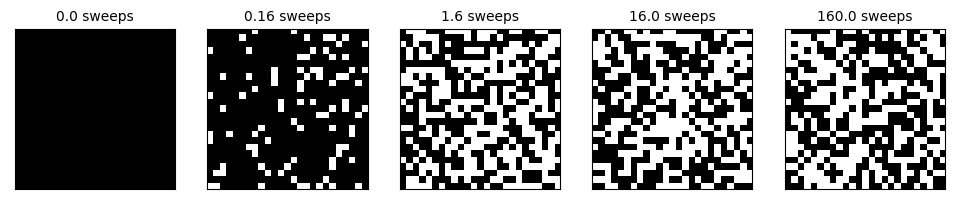

Ran in 2.2623672485351562 seconds


In [10]:
# Initialise lattice
lattice = make_lattice(25,1)
plot_times = [0,100,1000,10000,100000]
# Time run length:
print('Metropolis Hastings evolution, J = 0:')
start_time = time.time()
# Evolve
evolve_and_show(lattice, 2, 0,0, plot_times)
end_time = time.time()
print('Ran in ' + str(end_time - start_time) + ' seconds')

*Fig. 3*

Wolff Cluster evolution, J = 0:
Ran in 9.839225053787231 seconds


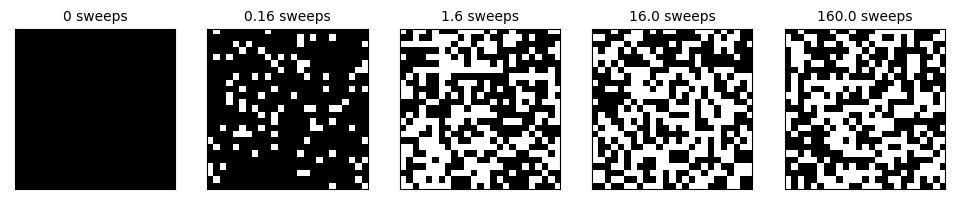

In [9]:
# Re-initialise lattice
lattice = make_lattice(25,1)
print('Wolff Cluster evolution, J = 0:')
# Time run length:
start_time = time.time()
# Evolve
Wolff_evolve_and_show(lattice, 2, 0, plot_times)

end_time = time.time()

print('Ran in ' + str(end_time - start_time) + ' seconds')

*Fig. 4*

This graphical evolution is similar for both algorithms, and performs as expected. Note that in this case, as $J = 0$, the probability of Wolff to add a second spin to the cluster is $0$, and hence Wolff flips only a single spin in each iteration. It is also clear that in this case the Wolff algorithm runs $\sim 5 \times$ slower. This will be explored further below.

Now, the algorithms will be implemented to determine their agreeability to the Onsager solution.

In [ ]:
#### SLOW ###

# Initialise lattices:
lattice_MH = make_lattice(25,1)
lattice_Wolff = make_lattice(25,1)

# Set temperatures to be evolved at:
Ts_MH = np.linspace(0.1,5,30)
Ts_Wolff = np.linspace(0.1,5,30)
# Initialise needed averaging times and observable array:
Ms_MH = []
Ms_Wolff = []
avg_times_MH = [100000, 150000, 200000]
avg_times_Wolff = [1000,1500,2000]

# Evolve and loop through Ts:
for T in Ts_MH:
    MH_Ms = evolve_and_compute_M(lattice_MH,T**-1, 1, 0, 200001)[0]
    Ms_MH.append(np.mean([MH_Ms[i] for i in avg_times_MH]))
for T in Ts_Wolff:
    Wolff_Ms = Wolff_evolve_and_compute_M(lattice_Wolff, T**-1,1,2001)[0]
    Ms_Wolff.append(np.mean([Wolff_Ms[i] for i in avg_times_Wolff]))

# Save data to be re used:
np.save('MH_M_against_T',Ms_MH)
np.save('Wolff_M_against_T',Ms_Wolff)

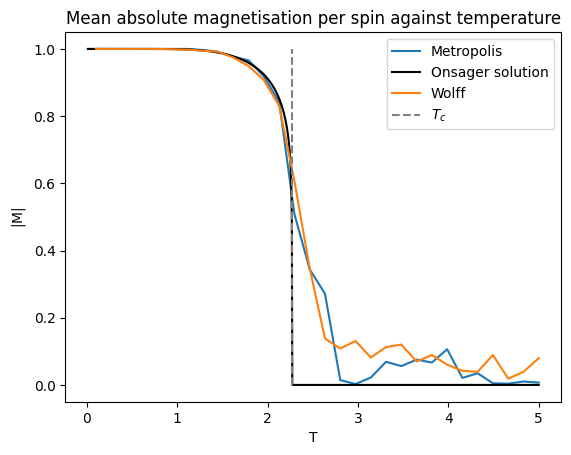

In [147]:
Ts_MH = np.linspace(0.1,5,30)
Ts_Wolff = np.linspace(0.1,5,30)
Ms_MH = np.load('MH_M_against_T.npy')
Ms_Wolff = np.load('Wolff_M_against_T.npy')
plt.plot(Ts_MH, np.abs(Ms_MH), label = 'Metropolis')
plt.plot(Ts_analytic, M_analytic, color = 'black', label  = 'Onsager solution')
plt.plot(Ts_Wolff, Ms_Wolff, label = 'Wolff')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title(r'Mean absolute magnetisation per spin against temperature')
plt.legend()
plt.show()

*Fig. 5*

It is clear that while the MH algorithm perfoms in accordance with the Onsager solution with $T$ far from $T_c$, the behaviour near the critical temperature deviates significantly from the Onsager solution. This a representation of the issue of *critical slowing down* for the MH algorithm. About the critical temperature, the lattice fluctuates on all scales. This behaviour cannot be reproduced by the local single spin flips by which MH proceeds, and hence to get a reliable simulation near $T_c$, an infeasibly large number of iterations is needed.

For the above behaviour to be sampled, the algorithm must have converged to near the stationary distribution for representative $\vert M \vert$ to be taken. The Wolff algorithm requires many fewer iterations to reach this point, for the above $\sim 10$ times fewer. This is due to the Wolff algorithm being less affected by critical slowing down, and is explored further below.

## Critical slowing down

The issue of critical slowing down is most present in the MH algorithm, around $T_c$. The lattice undergoes fluctuations on all scales which is not well captured by the single spin flips of MH. Hence, many iterations are required.

In [50]:
lattice1 = make_lattice(50,1)
lattice2 = make_lattice(50,1)
T1 = 2
T2 = 2.8
M1 = evolve_and_compute_M(lattice1, T1**-1,1,0,100000)[0]
M2 = evolve_and_compute_M(lattice2,T2**-1,1,0,100000)[0]
np.save('MH_M_below_T_c',M1)
np.save('MH_M_above_T_c',M2)

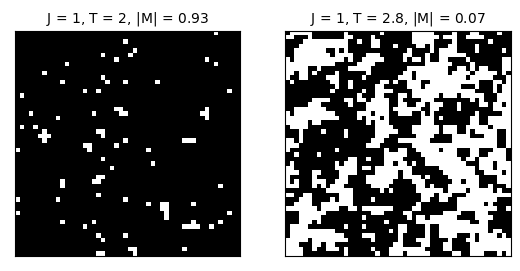

In [141]:
T1 = 2
T2 = 2.8
M1 = np.load('MH_M_below_T_c.npy')
M2 = np.load('MH_M_above_T_c.npy')
fig, ax = plt.subplots(1,2)
show_lattice(lattice1, ax[0], 'J = 1, T = ' + str(T1) + r', $\vert$M$\vert$ = ' + str(round(M1[-1],2)))
show_lattice(lattice2, ax[1], 'J = 1, T = ' + str(T2) + r', $\vert$M$\vert$ = ' + str(round(M2[-1],2)))

*Fig. 6*

The figure above illustrates the significant difference in structure over the lattice above and below $T_c$. At $T_c$, a very large proportion of the possibles states are thermodynamically likely, due to this being a phase transition. At this scale, the states remain correlated over many iterations and therefore generating independent samples requires significantly more iterations.  

## Autocorrelation Time

It is already clear that the MH algorithm perfoms less well than Wolff about the phase trasition, as MH takes many iterations to alter the lattice state significantly. This is equivalent to saying that the autocorrelation time becomes very large about $T_c$. The autocorrelation time measures the typical number of iterations (or sweeps) required between samples for these samples to be considered independent. Therefore for a large autocorrelation time, the number of iterations required to converge on equilibrium and the number required between independent samples become large and the process overall is less efficient.

To estimate the autocorrelation time, the *sample autocorrelation*, $\bar\rho(t)$ is required:

$\bar\rho(t) = \frac{\bar\gamma(t)}{\bar\gamma(0)}$ (17)

Where $\bar\gamma(t)$ is the *sample autocovariance*, defined below:

$\bar\gamma(t) = \frac{1}{n-t}\sum_{i=1}^{n-t}(f(X_i)-\bar f(X))(f(X_{i+t})-\bar f(X))$ (18)

This sample autocorrelation is a convenient measure of the degree of correlation of the observable $f$ on state $X_t$ at time $t$ with other states in the chain. To determine autocorrelation time, it is assumed that $\bar\rho(t)$ decays exponentially, with the characteristic decay scale of the autocorrelation time, $\tau_f$:

$\bar\rho(t) \approx e^{{t}/{\tau_f}}$ (19) [**CIT 5**]

Under this assumption, the autocorrelation time is estimated by the time of the first value of $\bar\rho(t)$ such that $\bar\rho(t) \le \frac{1}{e}$. Below is a set of functions to determine $\bar\gamma(t)$, $\bar\rho(t)$ and $\tau_f$ for a time series of magnetisation values:

In [11]:
def compute_autocovariance(observable, max_time):
    # Find array of differences from mean for the time series observable
    diff_from_mean = observable - np.mean(observable)
    # Return the sum term of equation (18). This is most conveniently done by dotting the appropriate list ranges together.
    return np.array([np.dot(diff_from_mean[:len(observable)-t],diff_from_mean[t:])/(len(observable)-1) for t in range(max_time)])

def estimate_correlation_time(autocov):
    # estimate the auto correlation time
    # firstly, if all covariances are so small they round to zero, correlation 
    # time is zero as system is equilibrated. For nz covariances, asssume they
    # have a well behaved exponential decay behaviour, and estimate correlation 
    # time as the index of the first value below autocov[0]/e:
    below_e = []
    if np.count_nonzero(autocov) == 0:
        correlation_time = 0
    else:
        for i in range(len(autocov)):
            if autocov[i] < np.exp(-1)*autocov[0]:
                below_e.append(i)
        correlation_time = below_e[0] if len(below_e) > 0 else len(autocov)
        
    return correlation_time

Not that, for values far from $T_c$, the autocorrelation is sufficiently small that python's 64-bit floats round it to zero. In this case, equation (19) can not be applied, and the autocorrelation time must be assumed to be $0$. The below code plots the sample autocorrelation against sweeps for different physical conditions using both the Wolff and MH algorithms:

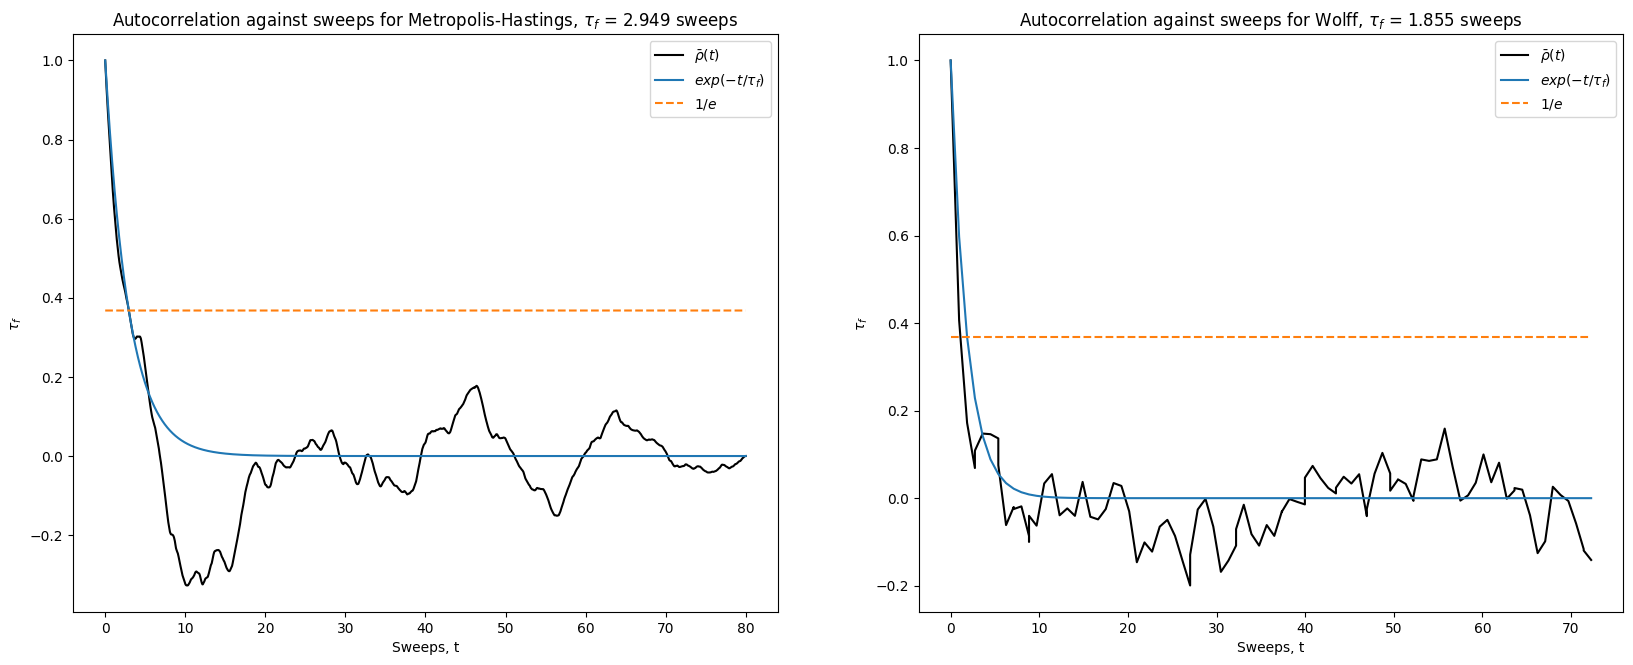

In [155]:
# Initialise for MH algorithm:
lattice = make_lattice(25,1)
max_time = 50000
T = 2.1

# Evolve the lattice with MH
Ms_MH, sweeps_MH = evolve_and_compute_M(lattice,T**-1,1,0,max_time)

# Find autocovariance, and the autocorrelation time (in sweeps)
autocov_MH = compute_autocovariance(Ms_MH, max_time)
tau_f_MH = estimate_correlation_time(autocov_MH)
sweeps_tau_f_MH = tau_f_MH/np.size(lattice)
# find sample autocorrelation (equation 17)
autocorr_MH = [x/autocov_MH[0] if x != 0 else 0 for x in autocov_MH]


# plot computed autocorrelation
fig, ax = plt.subplots(1,2, figsize = (20,7.5))
ax[0].plot(sweeps_MH,autocorr_MH, color = 'black', label = r'$\bar{\rho}(t)$')
# plot expected exponential decay behaviour
ax[0].plot(sweeps_MH,[np.exp(-t/sweeps_tau_f_MH) for t in sweeps_MH], label = r'$exp(-t/ \tau_f)$')
# plot 1/e line
ax[0].plot(sweeps_MH, [np.exp(-1) for x in sweeps_MH], label = r'$1/e$', linestyle = '--')
ax[0].set_xlabel('Sweeps, t')
ax[0].set_ylabel(r'$\tau_f$')
ax[0].set_title(r'Autocorrelation against sweeps for Metropolis-Hastings, $\tau_f$ = ' + str(round(sweeps_tau_f_MH,3)) + ' sweeps')
ax[0].legend()


# Load simulation data for Wolff as runtime much larger
sweeps_Wolff = np.load('Wolff_autocorr_evolution_sweeps.npy')
autocorr_Wolff = np.load('Wolff_autocorr_evolution_autocorr.npy')
sweeps_tau_f_Wolff = np.load('Wolff_auto_corr_evolution_sweeps_tau_f.npy')
# plot computed autocorrelation
ax[1].plot(sweeps_Wolff,autocorr_Wolff, color = 'black', label = r'$\bar{\rho}(t)$')
# plot expected exponential decay behaviour
ax[1].plot(sweeps_Wolff,[np.exp(-t/sweeps_tau_f_Wolff) for t in sweeps_Wolff], label = r'$exp(-t/ \tau_f)$')
# plot 1/e line
ax[1].plot(sweeps_Wolff, [np.exp(-1) for x in sweeps_Wolff], label = r'$1/e$', linestyle = '--')
ax[1].set_xlabel('Sweeps, t')
ax[1].set_ylabel(r'$\tau_f$')
ax[1].set_title(r'Autocorrelation against sweeps for Wolff, $\tau_f$ = ' + str(round(sweeps_tau_f_Wolff.tolist(),3)) + ' sweeps')
ax[1].legend()
plt.show()


*Fig. 7*

In [ ]:
#### SLOW ####

# Initialise
lattice = make_lattice(100,1)
max_time = 100
T = 2.1

# Evolve the lattice with Wolff
Ms, sweeps = Wolff_evolve_and_compute_M(lattice,T**-1,1,max_time)

# Find autocovariance, and the autocorrelation time (in sweeps)
autocov = compute_autocovariance(Ms, max_time)
sweeps_tau_f = sweeps[estimate_correlation_time(autocov)]
# Find sample autocorrelation (equation 17)
autocorr = [x/autocov[0] if x != 0 else 0 for x in autocov]
np.save('Wolff_autocorr_evolution_autocorr.npy', autocorr)
np.save('Wolff_autocorr_evolution_sweeps', sweeps)
np.save('Wolff_auto_corr_evolution_sweeps_tau_f.npy', sweeps_tau_f)

# plot computed autocorrelation
plt.plot(sweeps,autocorr, color = 'black', label = r'$\bar{\rho}(t)$')
# plot expected exponential decay behaviour
plt.plot(sweeps,[np.exp(-t/sweeps_tau_f) for t in sweeps], label = r'$exp(-t/ \tau_f)$')
# plot 1/e line
plt.plot(sweeps, [np.exp(-1) for x in sweeps], label = r'$1/e$', linestyle = '--')
plt.xlabel('Sweeps, t')
plt.ylabel(r'$\tau_f$')
plt.title(r'Autocorrelation against sweeps for Wolff, $\tau_f$ = ' + str(round(sweeps_tau_f,3)) + ' sweeps')
plt.legend()
plt.show()

*Fig. 8*

Both computed $\bar\rho(t)$ conform nicely to the expected exponential decay, with noisy behaviour that is apparent after a few autocorrelation times. It is also apparent that the autocorrelation time is smaller for the Wolff algorithm than the MH algorithm for the same given initial conditions. This is a reflection of the larger scale updates made by the Wolff algorithm, allowing it to explore the state space in fewer iterations. This is an indication that the Wolff algorithm has a less pronounced issue of ciritical slowing down. To explore this further, the dependence of autocorrelation time on temperature will be explored below:

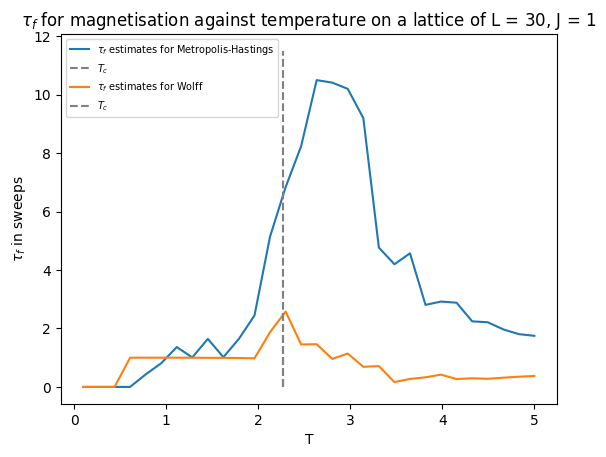

In [132]:

autocorr_times_MH = np.load('MH_autocorrelation_against_T.npy')
Ts = np.linspace(0.1,5,30)
# plot the data:
plt.plot(Ts,autocorr_times_MH, label = r'$\tau_f$ estimates for Metropolis-Hastings')
# mark T_c:
plt.plot(np.full((10,1),T_c),np.linspace(0,np.max(autocorr_times_MH)+1,10), color = 'gray', linestyle = '--', label = r'$T_c$')
plt.xticks([0,1,2,3,4,5])
plt.title(r'$\tau_f$ for magnetisation against temperature on a lattice of L = 30, J = 1')

autocorr_times_Wolff = np.load('Wolff_autocorrelation_against_T.npy')
plt.plot(Ts,autocorr_times_Wolff, label = r'$\tau_f$ estimates for Wolff')
plt.plot(np.full((2,1),T_c),np.linspace(0,np.max(autocorr_times_Wolff),2), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xticks([0,1,2,3,4,5])
plt.ylabel(r'$\tau_f$ in sweeps')
plt.xlabel('T')
plt.legend(loc = 'upper left', fontsize = 7)
plt.show()
T_c_Wolff = Ts[np.where(autocorr_times_Wolff == np.max(autocorr_times_Wolff))[0][0]]

T_c_MH = Ts[np.where(autocorr_times_MH == np.max(autocorr_times_MH))[0][0]]


*Fig. 9*

In [ ]:
### Slow ###

# Initialise required variables for MH tau against T:
Ts = np.linspace(0.1,5,30)
max_time = 50000
autocorr_times = []

for T in Ts:
    for i in range(5):
        # Lattice must be reset in each iteration
        lattice = make_lattice(30,1)
        # evolve the lattice
        Ms = evolve_and_compute_M(lattice, T**-1, 1, 0, max_time)[0]
        # find autocorrelation time and add to list.
        autocorr_times_i = []
        autocov = compute_autocovariance(Ms, max_time)
        sweeps_tau_f = estimate_correlation_time(autocov)/np.size(lattice)
        autocorr_times_i.append(sweeps_tau_f)
    autocorr_times.append(np.mean(autocorr_times_i))
    print(T)

# Initialise required variables for Wolff tau against T:
Ts = np.linspace(0.1,5,30)
max_time = 1000
autocorr_times = []

for T in Ts:
    for i in range(5):
        # Lattice must be reset after each iteration
        lattice = make_lattice(30,1)
        # evolve the lattice
        Ms, sweeps = Wolff_evolve_and_compute_M(lattice, T**-1, 1, max_time)
        # find autocorrelation time and add to list.
        autocorr_times_i = []
        autocov = compute_autocovariance(Ms, max_time)
        sweeps_tau_f = sweeps[estimate_correlation_time(autocov)]
        autocorr_times_i.append(sweeps_tau_f)
    autocorr_times.append(np.mean(autocorr_times_i))
    print(T)

#save arrays for use in report
np.save('Wolff_autocorrelation_against_T.npy', autocorr_times)
np.save('MH_autocorrelation_against_T', autocorr_times)

It is evident that the autocorrelation time for both algorithms is larger around $T_c$ than far from it. However, the Wolff algorithm maintains a smaller autocorrelation time around this point, again showing that the larger scale updates allow for much better modelling of the Ising model's phase transition. In fact, this cluster method produces a lower autocorrelation time on most measured temperatures. This is evidence that Wolff does not suffer as heavily from the issue of critical slowing down at the phase transition. The peak in autocorrelation time for MH is at a temprature a small amount above $T_c$. This partly is due to the fact that the Onsager solution assumes an infinite spatial extent of the lattice, whereas we have implemented a finite lattice with periodic boundaries, which yields:

$T_c(L) = T_c(\infty) +  \alpha L^{-1/\nu}$ (20)[**CIT 1**]

Where L is the lattice width, $\alpha$ is a constant and $\nu$ is the Ising model critical exponent.

This does not explain why MH and Wolff algorithms display different peak positions.

The value of the critical temperature for each method is estimated using the temperature of the maximum autocorrelation time, with discretisation error from the temperature scales considered in the error. These measured values are: $T_c = 2.63 \pm 0.08$ for MH and $T_c = 2.30 \pm 0.08$ for Wolff. The Onsager value is $T_c = 2.26(9...)$. This is consistent with the Wolff measurement and not with the MH.

The reduced equilibrium time of the Wolff algorithm is illustrated by the magnetisation graph below:

In [ ]:
#### SLOW ####

lattice = make_lattice(100,1)
T = 5
MH_Ms, MH_sweeps = evolve_and_compute_M(lattice, T**-1, 1,0,100000)
lattice = make_lattice(100,1)
Wolff_Ms, Wolff_sweeps = Wolff_evolve_and_compute_M(lattice,T**-1, 1, 100000)


Wolff_autocov = compute_autocovariance(Wolff_Ms, 100000)
Wolff_sweeps_tau_f = Wolff_sweeps[estimate_correlation_time(Wolff_autocov)]
np.save('MH_M_evolution.npy', MH_Ms)
np.save('MH_sweeps_evolution.npy', MH_sweeps)
np.save('Wolff_M_evolution.npy', Wolff_Ms)
np.save('Wolff_sweeps_evolution.npy', Wolff_sweeps)
np.save('Wolff_sweeps_tau_f.npy', Wolff_sweeps_tau_f)



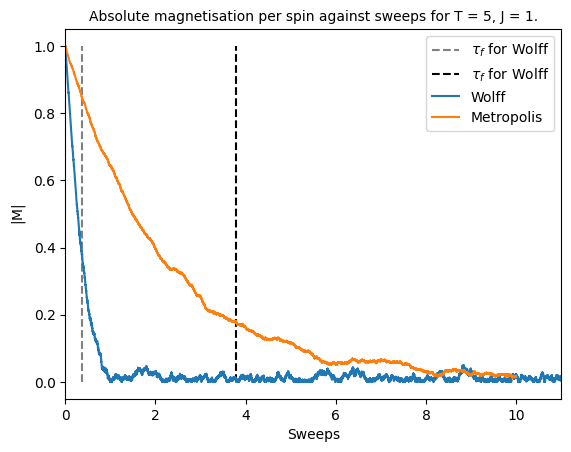

In [137]:
# Load simulation data:
Wolff_Ms = np.load('Wolff_M_evolution.npy')
Wolff_sweeps = np.load('Wolff_sweeps_evolution.npy')
Wolff_sweeps_tau_f = np.load('Wolff_sweeps_tau_f.npy')
MH_Ms = np.load('MH_M_evolution.npy')
MH_sweeps = np.load('MH_sweeps_evolution.npy')

plt.plot(np.full((3,1),Wolff_sweeps_tau_f),np.linspace(0,1,3), linestyle = '--', color = 'gray', label = r'$\tau_f$ for Wolff')
plt.plot(np.full((3,1),10*Wolff_sweeps_tau_f),np.linspace(0,1,3), linestyle = '--', color = 'black', label = r'$\tau_f$ for Wolff')
plt.plot(Wolff_sweeps, Wolff_Ms, label = 'Wolff')
plt.xlim((0,MH_sweeps[-1]+1))
plt.plot(MH_sweeps,MH_Ms, label = 'Metropolis')
plt.xlabel('Sweeps')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Absolute magnetisation per spin against sweeps for T = ' + str(T) + ', J = 1.', fontsize = 10)
plt.legend()
plt.show()


*Fig. 11*

### Dynamic exponent

The issue of critical slowing down can be further quantified for the twwo methods here by measurement of the *dynamic exponent*, $z$:

$\tau_f \sim \xi^z \sim \vert T - T_c \vert ^{z \nu}$ (21) [**CIT 3**]

where $\xi$ is the correlation length, $\nu$ is the critical exponent, which is a universal property of the ising model and will not be measured in this report.

On a finite lattice of length $L$, the correlation length cannot exceed $L$.Therefore we expect the correlation length near $T_c$ to approximately equal the system length. This yields:

$\tau_f \sim L^z$ for $T \sim T_c$ (22)

$ln(\tau_f) \sim zln(L)$ (23)

###FINISH

In [ ]:
#####SLOW#####

lattice_widths = np.arange(2,30,1)
MH_autocorr_time_against_width = []

for width in lattice_widths:
    for i in range(5):
        MH_temp = []
        lattice = make_lattice(width,1)
        Ms, sweeps = evolve_and_compute_M(lattice,T_c_MH**-1,1,0,10000)
        MH_autocov = compute_autocovariance(Ms,10000)
        MH_temp.append(estimate_correlation_time(MH_autocov))
    MH_autocorr_time_against_width.append(np.mean(MH_temp))
    print(MH_autocorr_time_against_width)

Wolff_autocorr_time_against_width = []
lattice_widths = np.arange(2,30,1)
for width in lattice_widths:
    for i in range(5):
        Wolff_temp = []
        lattice = make_lattice(width,1)
        Ms, sweeps = Wolff_evolve_and_compute_M(lattice,T_c_Wolff**-1,1,1001)
        Wolff_autocov = compute_autocovariance(Ms,100)
        Wolff_temp.append(estimate_correlation_time(Ms))
    Wolff_autocorr_time_against_width.append(np.mean(Wolff_temp))
    print(Wolff_autocorr_time_against_width)


np.save('MH_autocorr_time_against_width.npy', MH_autocorr_time_against_width)
np.save('Wolff_autocorr_time_against_width.npy', Wolff_autocorr_time_against_width)

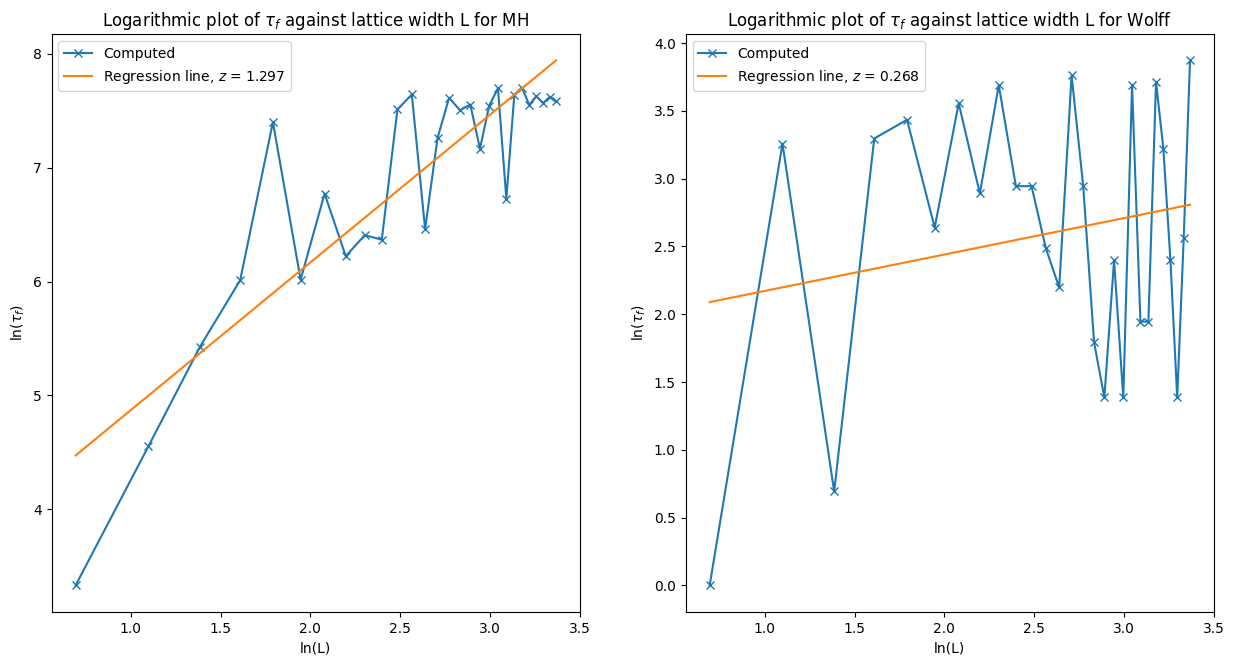

In [139]:
# data loading and initialisation:
lattice_widths = np.arange(2,30,1)
MH_autocorr_time_against_width = np.load('MH_autocorr_time_against_width.npy')
Wolff_autocorr_time_against_width = np.load('Wolff_autocorr_time_against_width.npy')
lnL = np.log(lattice_widths)
lnMH_autocorr_time_against_width = np.log(MH_autocorr_time_against_width)
lnWolff_autocorr_time_against_width = np.log(Wolff_autocorr_time_against_width)
fig, ax = plt.subplots(1,2, figsize = (15,7.5))

# Linear regression for MH
A = np.vstack([lnL, np.ones(len(lnMH_autocorr_time_against_width))]).T
m, c = np.linalg.lstsq(A,lnMH_autocorr_time_against_width, rcond = None)[0]
# Plot
ax[0].plot(lnL, lnMH_autocorr_time_against_width, marker = 'x', label = 'Computed')
ax[0].plot(lnL, m*lnL+c,  label = r'Regression line, $z$ = ' + str(np.round(m, 3)))
ax[0].set_xlabel('ln(L)')
ax[0].set_ylabel(r'ln($\tau_f$)')
ax[0].set_title(r'Logarithmic plot of $\tau_f$ against lattice width L for MH')
ax[0].legend()

# Linear regression for wolff
A = np.vstack([lnL, np.ones(len(lnWolff_autocorr_time_against_width))]).T
m, c = np.linalg.lstsq(A,lnWolff_autocorr_time_against_width, rcond = None)[0]
# Plot:
ax[1].plot(lnL, lnWolff_autocorr_time_against_width, marker = 'x', label = 'Computed')
ax[1].plot(lnL, m*lnL+c,  label = r'Regression line, $z$ = ' + str(np.round(m, 3)))
ax[1].set_xlabel('ln(L)')
ax[1].set_ylabel(r'ln($\tau_f$)')
ax[1].set_title(r'Logarithmic plot of $\tau_f$ against lattice width L for Wolff')
ax[1].legend()
plt.show()

The measured values for $z$ are $1.297$ and $0.268$ for Metropolis-Hastings and Wolff respectively. This is not in agreement with previously measured values ($2.11 \pm 0.073$ and $0.47 \pm 0.051$ [**CIT 9**]) respectively. The two plots above do not bear enough resemblance to a linear relationship for the regression variables calculated to be treated seriously. There are many reasons that could contribute to this error. Firstly, the approximations made to calculate the auto correlation time in equation (18) are rough, and it is clear from figures seven and 8 that although the data and exponential decay initially coincide, there is significant deviation for $t \sim 2 \tau_f$ and beyond. This could lead to an erroneous measurement of $\tau_f$ and the discrepancy above. However, this is unlikely to fully account for the error, as other investigation that used $\tau_f$ are in agreement with predicted values. Further investigation is needed to determine the source of this discrepancy.

### Complexity

A discussion of the utility of a computational technique must include consideration of the computation time and its dependence on the variables at hand. It is alreaady apparent that the MH algorithm will take many iterations to reach the desired final state around the phase transition. However, the process of cluster creation in the Wolff algoithm requires using the pop function many times per iteration, which is $O(N)$[**CIT 2**], where $N$ is the length of the list to which it is applied. This suggests that a typical Wolff  iteration is more computationally intense than a typical MH iteration. The complexity of these algorithms is investigated below.

In [ ]:
#### SLOW ####

# Coupling complexity:

Js = np.linspace(0,10,50)
Wolff_execute_time = []
MH_execute_time = []

for J in Js:
    lattice = make_lattice(100,1)
    start = time.time()
    Wolff_spin_flip(lattice,1,J)
    end = time.time()
    Wolff_execute_time.append(end-start)
    lattice = make_lattice(100,1)
    start = time.time()
    MC_spin_flip(lattice,1,J,0)
    end = time.time()
    MH_execute_time.append(end - start)

np.save('MH_execute_time_against_J.npy', MH_execute_time)
np.save('Wolff_execute_time_against_J.npy', Wolff_execute_time)

#Lattice size compplexity:

lattice_widths = np.arange(25,500,25)
Wolff_execute_time = []
MH_execute_time = []

for width in lattice_widths:
    lattice = make_lattice(width,1)
    start = time.time()
    Wolff_spin_flip(lattice,1,1)
    end = time.time()
    Wolff_execute_time.append(end-start)
    lattice = make_lattice(width,1)
    start = time.time()
    MC_spin_flip(lattice,1,1,0)
    end = time.time()
    MH_execute_time.append(end - start)

np.save('MH_execute_time_against_width.npy', MH_execute_time)
np.save('Wolff_execute_time_against_width.npy', Wolff_execute_time)

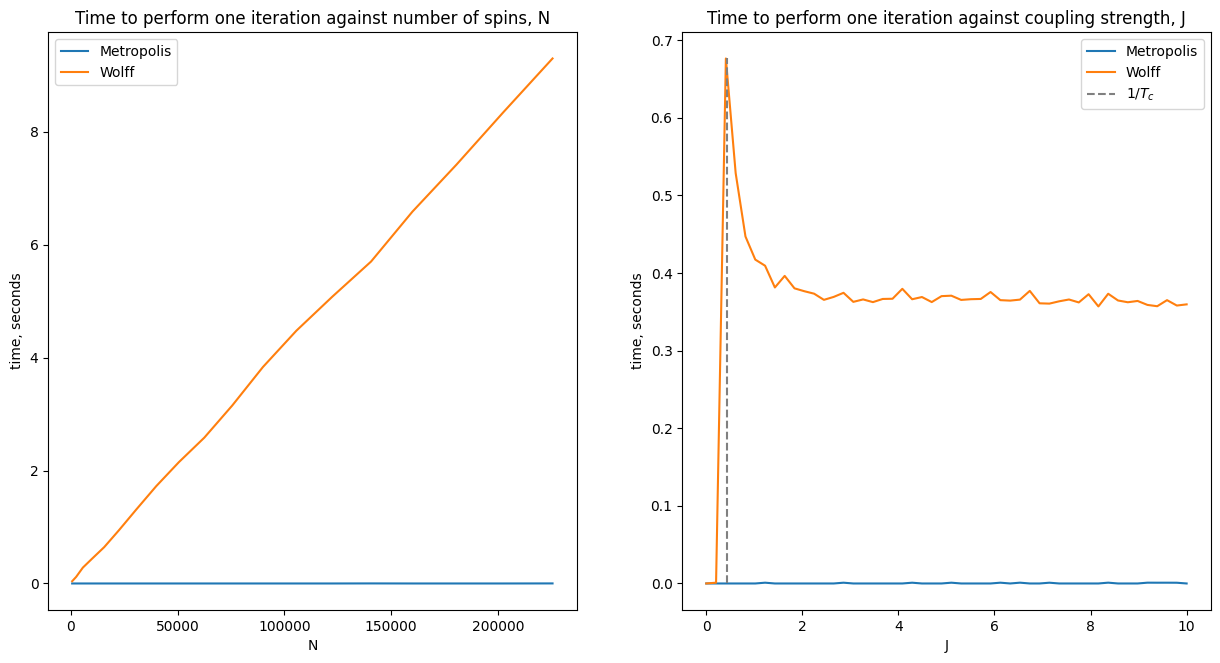

In [138]:
Js = np.linspace(0,10,50)
lattice_widths = np.arange(25,500,25)
fig, ax = plt.subplots(1,2, figsize = (15,7.5))
MH_execute_time_width = np.load('MH_execute_time_against_width.npy')
Wolff_execute_time_width = np.load('Wolff_execute_time_against_width.npy')
MH_execute_time_J = np.load('MH_execute_time_against_J.npy')
Wolff_execute_time_J = np.load('Wolff_execute_time_against_J.npy')

ax[1].plot(Js, MH_execute_time_J, label = 'Metropolis')
ax[1].plot(Js,Wolff_execute_time_J, label = 'Wolff')
ax[1].plot(np.full((5,1),T_c**-1),np.linspace(0,np.max(Wolff_execute_time_J),5), linestyle = '--', color = 'gray', label = r'$1/T_c$')
ax[1].legend()
ax[1].set_xlabel('J')
ax[1].set_ylabel('time, seconds')
ax[1].set_title('Time to perform one iteration against coupling strength, J')

ax[0].plot(lattice_widths**2, MH_execute_time_width, label = 'Metropolis')
ax[0].plot(lattice_widths**2, Wolff_execute_time_width, label = 'Wolff')
ax[0].legend()
ax[0].set_xlabel('N')
ax[0].set_ylabel('time, seconds')
ax[0].set_title('Time to perform one iteration against number of spins, N')
plt.show()

*Fig. 12*

This figure shows that an iteration of the Wolff algorithm takes longer than an MH algorithm generally as expected. The MH step has no noticeable dependance on either of $J$ or $N$. Wolff iterations display a linear dependence on $N$, and a complex dependence on $J$, with a pronounced peak at $\frac{1}{T_c}$ that then settles to an approximately constant time.

However, overall computational efficiency in this context requires the algorithms to converge on the stationary distibution. It has already been shown that the number of iterations required to satisfy this differs greatly between Wolff and MH, due to the significant difference in autocorrelation times and extent of critical slowing down. This implies that although WOlff iterations are more computationally expensive, the shorter autocorrelation time, especiually in the vicinity of $T_c$ implies that Wolff will take many fewer iterations to generate a series of independent lattice samples, and will therfore in the large time limit be more computationally efficient. 

## Section 5 - Conclusion

## References

1. *The Hobbyhorse of Magnetic Systems: The Ising Model*, Padilla et al., 2016, European Journal of Physics
2. *TimeComplexity*, AndrewBadr, 2023, https://wiki.python.org/moin/TimeComplexity
3. *Comparison of Monte Carlo Metropolis, Swendsen-Wang, and Wolff Algorithms in the Critical Region for the 2-dimensional Ising Model*, Kyimba et al., 2022, NC State University
4. *Part II computational physics, Monte Carlo methods*, Lamacraft et al., 2023, University of Cambridge, https://computational-physics.tripos.org/notes/monte-carlo.html
5. *Monte Carlo Techniques, 5. MCMC in practice*, Budd, 2022, Radboud University, https://hef.ru.nl/~tbudd/mct/lectures/mcmc_in_practice.html
6. *Spin Glass Models 4: Ising Model-Simulation*, Cole, 2020, https://lewiscoleblog.com/spin-glass-models-4
7. *Thermal and Statistical Physics Supplementary Course Handout*, Terentjev, 2022, University of Cambridge, https://www-teach.phy.cam.ac.uk/dms/dms_getFile.php?node=43344
8. *Parallelization of the Wolff Single-Cluster Algorithm*, Kaupužs et al., 2010, University of Latvia
9. *Monte-Carlo simulations in the 2-dimensional Ising Model*, Bourached, 2015, Trinity College Dublin

## Appendices
#### 1. Computer specifications
All tests were run in python 3.10.1 on a PC with Windows 11 home version 10.0.22621 N/A Build 22621. The CPU is an Intel Core i5-8265U with 4 cores and a base speed of 1.80GHz. 8GB of RAM is available, as well as an NVIDIA GeForce GTX 1650 Max-Q with 4GB dedicated VRAM and 4GB shared.
